# Prototype Model
這個模型使用簡單的價量資料，預測單一個股漲跌，作為後續模型的原型

In [140]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression

from module import *
import xgboost

pd.options.mode.chained_assignment = None  # default='warn'

## Load Price Data

In [2]:
price = load_price_data()
price.head(3)

/Users/stuartlu/Documents/國泰人壽/ML 選股/module.py:24: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv(path, encoding='cp950')


Open     High      Low    Close  Volume  QuoteVolume   
證券代碼    年月日                                                                   
1101 台泥 2015-01-05  20.3688  20.3688  20.0872  20.1810    2842       122244  \
        2015-01-06  19.9464  19.9933  19.7586  19.8290    7654       324150   
        2015-01-07  19.8290  19.9698  19.6413  19.7586    8719       368171   

                    MarketCap  YSTD Close  TMR Close  Daily Return  
證券代碼    年月日                                                         
1101 台泥 2015-01-05     158764         NaN    19.8290     -0.017596  
        2015-01-06     155994      20.181    19.7586     -0.003557  
        2015-01-07     155441      19.829    19.8290      0.003557

## Load Feature Data

In [5]:
data = load_fundamental_data('./data/ifrs.csv')
data.head(3)

年月  季別  月份   現金及約當現金  透過損益按公允價值衡量之金融資產－流動   
證券代碼    財報發布日                                                        
1101 台泥 2015-05-15  2015-03   1   3  31406216               146388  \
        2015-08-14  2015-06   2   6  35848634               145919   
        2015-11-13  2015-09   3   9  35931378               148581   

                    透過其他綜合損益按公允價值衡量之金融資產－流動  按攤銷後成本衡量之金融資產－流動  避險之金融資產－流動   
證券代碼    財報發布日                                                               
1101 台泥 2015-05-15               19582139.0                 0         0.0  \
        2015-08-14               18260651.0                 0         0.0   
        2015-11-13               16358225.0                 0         0.0   

                    合約資產－流動     應收帳款及票據  ...  當季季底P/E  當季季底P/B  當季季底PSR   
證券代碼    財報發布日                            ...                              
1101 台泥 2015-05-15      0.0  21758400.0  ...     8.53     1.38     1.44  \
        2015-08-14      0.0  21357337.0  ...     8.96     1.31     1.35   
        2015-11-13      0.0  19703043.0  ...    11.07     1.12     1.25   

                    財報類別（1個別2個體3合併）   財報年月起日   財報年月迄日  交易所主產業代碼  交易所子產業代碼   
證券代碼    財報發布日                                                               
1101 台泥 2015-05-15                3  2015/01  2015/03     M1100     M1100  \
        2015-08-14                3  2015/01  2015/06     M1100     M1100   
        2015-11-13                3  2015/01  2015/09     M1100     M1100   

                    TEJ主產業代碼  TEJ子產業代碼  
證券代碼    財報發布日                           
1101 台泥 2015-05-15       11A       11A  
        2015-08-14       11A       11A  
        2015-11-13       11A       11A  

[3 rows x 245 columns]

In [6]:
fundamental_features = ['年月', 'ROA', 'EBITDA', 'ROE', 'Gross Profit', 'Revenue Growth', 'Net Operating Revenue', 'P/E Ratio', 'P/B Ratio', 'PSR']

def select_features(data, features = ['年月', 'ROA－綜合損益','稅前息前折舊前淨利率', 'ROE－綜合損益', '營業毛利率', '營收成長率', '營業收入淨額', '當季季底P/E', '當季季底P/B', '當季季底PSR'], rename = fundamental_features):
    data = data.rename(columns = dict(zip(features, rename)))
    return data[rename]

selected_features = select_features(data)
selected_features

年月   ROA  EBITDA   ROE  Gross Profit   
證券代碼     財報發布日                                                   
1101 台泥  2015-05-15  2015-03  0.07   17.52  0.12         13.34  \
         2015-08-14  2015-06  0.20   21.77  0.38         15.67   
         2015-11-13  2015-09  0.23   15.82  0.45         14.57   
         2016-03-31  2015-12 -0.71   21.06 -1.33         18.09   
         2016-05-13  2016-03 -0.26   14.74 -0.47          8.95   
...                      ...   ...     ...   ...           ...   
9958 世紀鋼 2023-05-15  2023-03 -0.03   10.15 -0.09          6.17   
         2023-08-11  2023-06  0.66   18.25  2.13         13.36   
         2023-11-13  2023-09  1.29   24.85  4.05         18.36   
         2024-03-08  2023-12  2.10   26.35  5.90         24.20   
         2024-05-14  2024-03  3.56   46.44  8.33         37.76   

                     Revenue Growth  Net Operating Revenue  P/E Ratio   
證券代碼     財報發布日                                                          
1101 台泥  2015-05-15          -19.75               21440142       8.53  \
         2015-08-14          -21.58               24994185       8.96   
         2015-11-13          -24.63               22683975      11.07   
         2016-03-31          -17.14               24560774      11.80   
         2016-05-13          -17.33               17724112      15.82   
...                             ...                    ...        ...   
9958 世紀鋼 2023-05-15           20.31                2675284    -888.00   
         2023-08-11           84.90                3218818    -888.00   
         2023-11-13           57.61                3645290     156.81   
         2024-03-08           68.99                4976206      25.39   
         2024-05-14           17.71                3148958      20.65   

                     P/B Ratio   PSR  
證券代碼     財報發布日                        
1101 台泥  2015-05-15       1.38  1.44  
         2015-08-14       1.31  1.35  
         2015-11-13       1.12  1.25  
         2016-03-31       0.93  1.08  
         2016-05-13       1.08  1.29  
...                        ...   ...  
9958 世紀鋼 2023-05-15       3.17   NaN  
         2023-08-11       4.35   NaN  
         2023-11-13       5.41   NaN  
         2024-03-08       4.69   NaN  
         2024-05-14       4.77   NaN  

[35552 rows x 10 columns]

In [7]:
data_seasonal = merge_feature_data(selected_features, price, return_mode='simple')
data_seasonal

,,,,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,Open,...,Low,Close,Volume,QuoteVolume,MarketCap,YSTD Close,TMR Close,Daily Return,YSTD Close Shift,Seasonal Return
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2015-05-15,2015-05-15,2015-03,0.07,17.52,0.12,13.34,-19.75,21440142.0,8.53,1.38,1.44,20.0402,...,19.8760,19.9464,4962,211254,156917,20.0402,20.1810,0.011693,16.9923,-0.158005
1102 亞泥,2015-05-15,2015-05-15,2015-03,1.92,24.17,3.33,10.63,-5.50,15362530.0,11.69,0.90,1.73,22.3520,...,22.2065,22.2356,1848,70740,128407,22.3229,22.4393,0.009119,20.1983,-0.099869
1103 嘉泥,2015-05-13,2015-05-13,2015-03,-1.91,-10.98,-3.34,-11.27,-34.14,671355.0,164.13,0.64,2.99,9.6688,...,9.6345,9.6688,115,1617,10953,9.6345,9.5316,-0.014292,7.3373,-0.230213
1104 環泥,2015-05-14,2015-05-14,2015-03,1.57,23.09,1.93,8.30,-3.75,1327430.0,12.26,1.14,3.15,16.6657,...,16.1193,16.2286,326,9707,18294,16.3925,16.0100,-0.013562,13.6826,-0.145372
1108 幸福,2015-05-14,2015-05-14,2015-03,1.89,23.41,3.34,20.98,5.54,1286874.0,8.25,0.94,0.87,7.1766,...,7.1083,7.1425,546,5757,4230,7.2108,7.4159,0.037563,7.2350,-0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945 潤泰新,2024-05-13,2024-05-13,2024-03,5.51,142.72,9.41,25.53,11.16,7000524.0,7.02,0.97,NaN,39.6262,...,39.5778,42.4808,45390,1940083,124861,39.1907,41.2712,-0.028887,NaN,NaN
9946 三發地產,2024-05-10,2024-05-10,2024-03,1.02,16.02,2.40,29.02,90.84,301274.0,62.91,1.24,NaN,37.0000,...,36.6500,36.9000,2294,85828,12050,36.7000,38.0000,0.029375,NaN,NaN
9955 佳龍,2024-05-08,2024-05-08,2024-03,-1.04,-2.54,-2.28,-0.81,3.92,272888.0,-888.00,1.99,NaN,30.5500,...,29.9000,30.6000,1207,36566,3158,30.8000,29.4000,-0.040005,NaN,NaN


## Scaling and Imputing Data

In [152]:
def scale_data(data):
    
    returns_preserved = data['Seasonal Return'] #preseve return from any modification
    data_scaled = pd.DataFrame(scale(data), index = data.index, columns = data.columns) #scaling data
    data_scaled['Seasonal Return'] = returns_preserved #append back preserved return
    
    return data_scaled

def impute_data(data):
    
    returns_preserved = data['Seasonal Return'] #preseve return from any modification
    #imp = SimpleImputer(strategy='mean') #imputing data
    #imp.fit(data)
    #data_imputed = pd.DataFrame(imp.transform(data), index = data.index, columns = data.columns)
    data_imputed = data.groupby('證券代碼').fillna(method='ffill').fillna(0)
    data_imputed['Seasonal Return'] = returns_preserved #append back preserved return

    return data_imputed


data_scaled = scale_data(data_seasonal)
data_imputed = impute_data(data_scaled)
data_imputed

,,,,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,Open,...,Low,Close,Volume,QuoteVolume,MarketCap,YSTD Close,TMR Close,Daily Return,YSTD Close Shift,Seasonal Return
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2015-05-15,2015-05-15,2015-03,-0.294548,0.025785,-0.124971,-0.204496,-0.020126,0.233164,-0.005899,-0.170762,-0.020352,-0.235656,...,-0.235258,-0.236335,0.108409,-0.001695,0.316712,-0.235823,-0.235587,0.411396,-0.258452,-0.158005
1102 亞泥,2015-05-15,2015-05-15,2015-03,0.287105,0.027365,0.137753,-0.266273,-0.019715,0.118184,-0.005690,-0.331009,-0.020091,-0.218768,...,-0.217885,-0.219557,-0.113654,-0.110852,0.238414,-0.219062,-0.218983,0.322707,-0.235087,-0.099869
1103 嘉泥,2015-05-13,2015-05-13,2015-03,-0.917074,0.019013,-0.408155,-0.765507,-0.020541,-0.159752,0.004362,-0.417809,-0.018957,-0.311421,...,-0.311604,-0.311665,-0.237236,-0.164549,-0.084154,-0.312227,-0.313885,-0.484052,-0.328816,-0.230213
1104 環泥,2015-05-14,2015-05-14,2015-03,0.177063,0.027109,0.023169,-0.319388,-0.019665,-0.147340,-0.005653,-0.250886,-0.018813,-0.260308,...,-0.263263,-0.263585,-0.222189,-0.158264,-0.063993,-0.262606,-0.266254,-0.458895,-0.282572,-0.145372
1108 幸福,2015-05-14,2015-05-14,2015-03,0.277673,0.027185,0.138571,-0.030334,-0.019397,-0.148107,-0.005917,-0.317655,-0.020865,-0.329627,...,-0.330436,-0.330182,-0.206501,-0.161333,-0.102618,-0.330023,-0.329440,1.302918,-0.329562,-0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945 潤泰新,2024-05-13,2024-05-13,2024-03,1.415826,0.055533,0.635372,0.073389,-0.019235,-0.040013,-0.005998,-0.307640,-0.018417,-0.092577,...,-0.088389,-0.071169,2.991373,1.341319,0.228676,-0.095210,-0.080524,-0.987031,-0.096673,NaN
9946 三發地產,2024-05-10,2024-05-10,2024-03,0.004139,0.025429,0.061637,0.152947,-0.016939,-0.166754,-0.002313,-0.217501,-0.020073,-0.111762,...,-0.110215,-0.112073,-0.081849,-0.099131,-0.081142,-0.113498,-0.104575,1.020723,-0.114825,NaN
9955 佳龍,2024-05-08,2024-05-08,2024-03,-0.643540,0.021019,-0.321399,-0.527060,-0.019444,-0.167291,-0.065016,0.032884,-0.019866,-0.158880,...,-0.160533,-0.158249,-0.159364,-0.137399,-0.105562,-0.156819,-0.167806,-1.370169,-0.157824,NaN


In [153]:
def polynomial_transform(data):

    returns_preserved = data['Seasonal Return'] #preseve return from any modification
    data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'QuoteVolume',	'YSTD Close', 'TMR Close', 'Daily Return', 'YSTD Close Shift', 'Seasonal Return'], inplace=True)
    poly = PolynomialFeatures(interaction_only=False)
    poly.fit(data)
    data_transformed = pd.DataFrame(poly.transform(data), index = data.index, columns = poly.get_feature_names_out(data.columns))
    data_transformed['Seasonal Return'] = returns_preserved #append back preserved return

    return data_transformed


data_imputed = polynomial_transform(data_imputed)

## Labeling

In [154]:
#compute period mean
data_imputed = data_imputed.sort_index(level=2)
data_imputed['Cross Section Median'] = data_imputed.groupby('年月')['Seasonal Return'].transform('median')
print(data_imputed['Cross Section Median'])

證券代碼      財報發布日       年月日         年月     
1414 東和   2015-04-22  2015-04-22  2015-03   -0.145550
3504 揚明光  2015-04-24  2015-04-24  2015-03   -0.145550
1560 中砂   2015-04-28  2015-04-28  2015-03   -0.145550
2308 台達電  2015-04-28  2015-04-28  2015-03   -0.145550
2455 全新   2015-04-28  2015-04-28  2015-03   -0.145550
                                               ...   
2888 新光金  2024-05-28  2024-05-28  2024-03   -0.130183
2892 第一金  2024-05-28  2024-05-28  2024-03   -0.130183
5880 合庫金  2024-05-28  2024-05-28  2024-03   -0.130183
2880 華南金  2024-05-29  2024-05-29  2024-03   -0.130183
1773 勝一   2024-07-16  2024-07-16  2024-06         NaN
Name: Cross Section Median, Length: 33707, dtype: float64


In [155]:
data_imputed = data_imputed.sort_index(level=2)
data_imputed

,,,,1,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,...,P/E Ratio PSR,P/E Ratio MarketCap,P/B Ratio^2,P/B Ratio PSR,P/B Ratio MarketCap,PSR^2,PSR MarketCap,MarketCap^2,Seasonal Return,Cross Section Median
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1414 東和,2015-04-22,2015-04-22,2015-03,1.0,-0.470616,0.021508,-0.196176,-0.525465,-0.019848,-0.166835,0.023815,-0.441179,-0.020397,...,-0.000486,-0.002603,0.194639,0.008999,0.048212,0.000416,0.002229,0.011942,-0.116454,-0.145550
3504 揚明光,2015-04-24,2015-04-24,2015-03,1.0,-0.410878,0.023525,-0.170804,0.079543,-0.019914,-0.152576,-0.004615,-0.050577,-0.020334,...,0.000094,0.000437,0.002558,0.001028,0.004789,0.000413,0.001925,0.008966,-0.469792,-0.145550
1560 中砂,2015-04-28,2015-04-28,2015-03,1.0,0.588936,0.028007,0.181131,0.204466,-0.019586,-0.153210,-0.005765,0.156408,-0.019704,...,0.000114,0.000514,0.024463,-0.003082,-0.013948,0.000388,0.001757,0.007953,-0.107103,-0.145550
2308 台達電,2015-04-28,2015-04-28,2015-03,1.0,0.114181,0.025490,0.077187,0.084103,-0.019545,0.644887,-0.005229,0.890871,-0.019380,...,0.000101,-0.006211,0.793652,-0.017265,1.058186,0.000376,-0.023020,1.410892,-0.109211,-0.145550
2455 全新,2015-04-28,2015-04-28,2015-03,1.0,0.739851,0.030872,0.176220,0.380908,-0.018417,-0.162525,-0.005453,0.253223,-0.017733,...,0.000097,0.000486,0.064122,-0.004490,-0.022549,0.000314,0.001579,0.007930,0.209268,-0.145550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888 新光金,2024-05-28,2024-05-28,2024-03,1.0,-0.219090,0.000000,0.360372,0.000000,-0.009777,0.174936,-0.002654,-0.471225,-0.016788,...,0.000045,-0.000713,0.222053,0.007911,-0.126559,0.000282,-0.004509,0.072132,NaN,-0.130183
2892 第一金,2024-05-28,2024-05-28,2024-03,1.0,-0.241099,0.000000,0.217143,0.000000,-0.019396,0.181832,-0.005583,-0.147393,-0.016815,...,0.000094,-0.005220,0.021725,0.002478,-0.137811,0.000283,-0.015722,0.874207,NaN,-0.130183
5880 合庫金,2024-05-28,2024-05-28,2024-03,1.0,-0.269395,0.000000,0.097648,0.000000,-0.019351,0.126466,-0.005339,-0.110670,-0.015888,...,0.000085,-0.005041,0.012248,0.001758,-0.104491,0.000252,-0.015001,0.891449,NaN,-0.130183


In [158]:
#data_train, data_test = train_test_split(data_imputed, test_size = 0.5, random_state=0, shuffle=False)
data_train = data_imputed[data_imputed.index.get_level_values(2) < '2020-01-01']
data_test = data_imputed[data_imputed.index.get_level_values(2) >= '2020-01-01']

features_used = ['ROA', 'EBITDA', 'ROE', 'Gross Profit', 'Revenue Growth', 'Net Operating Revenue', 'P/E Ratio', 'P/B Ratio', 'PSR']

#reg = LogisticRegression(max_iter = 2000)
reg = xgboost.XGBClassifier(max_depth = 2, n_estimators = 50)
reg.fit(data_train.drop(columns = ['Seasonal Return', 'Cross Section Median']), data_train['Seasonal Return'] > data_train['Cross Section Median'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [159]:
score_insample = reg.score(data_train.drop(columns = ['Seasonal Return', 'Cross Section Median']), data_train['Seasonal Return'] > data_train['Cross Section Median'])
score_outsample = reg.score(data_test.drop(columns = ['Seasonal Return', 'Cross Section Median']), data_test['Seasonal Return'] > data_test['Cross Section Median'])

print(f'In sample score: {score_insample}')
print(f'Out sample score: {score_outsample}')

In sample score: 0.5945389598595386
Out sample score: 0.5358929610238511


## Backtest

In [160]:
def return_summary(series):
    mean = series.mean()
    std = series.std()
    sharpe = mean / std
    annual_sharpe = sharpe * (252)**(0.5)
    annual_return_simple = mean*252
    annual_return_compounded = np.exp(mean*252)-1
    print(f'Annual Sharpe: {annual_sharpe}')
    print(f'Annual Return (Simple): {annual_return_simple}')
    print(f'Annual Return (Compounded): {annual_return_compounded}')

def backtest_daily():
    history = data_imputed.copy()
    history['Logistic Prediction'] = reg.predict(history.drop(columns = ['Seasonal Return', 'Cross Section Median']))
    history = history.reset_index()
    history.set_index(['證券代碼', '年月日'], inplace=True)
    history_merged = price[['Daily Return']].merge(history[['Logistic Prediction']], left_index=True, right_index=True, how='outer')
    history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')

    history_merged.reset_index(inplace=True)
    dates = sorted(list(set(history_merged['年月日'])))

    seasonal_returns_long = []
    seasonal_returns_short = []
    for date in dates:
        print(date)
        current_stocks = history_merged[history_merged['年月日'] == date]
        buy_stock = current_stocks[current_stocks['Logistic Prediction'] == True]
        sell_stock = current_stocks[current_stocks['Logistic Prediction'] == False]

        print('Long stocks: ' + str(list(buy_stock['證券代碼'])))
        print('Short stocks: ' + str(list(sell_stock['證券代碼'])))
        print(f'Stock bought: {len(list(buy_stock["證券代碼"]))}, Stock shorted: {len(list(sell_stock["證券代碼"]))}, Total: {len(list(buy_stock["證券代碼"]))+len(list(sell_stock["證券代碼"]))}')
        long = buy_stock['Daily Return'].mean()
        short = -sell_stock['Daily Return'].mean()
        seasonal_returns_long.append(long)
        seasonal_returns_short.append(short)

    long_portfolio = pd.Series(seasonal_returns_long, index = dates)
    short_portfolio = pd.Series(seasonal_returns_short, index = dates)
    return long_portfolio, short_portfolio

def plot_portfolio(portfolio, long = 0, short = 0, tc = 0.0001):
    n = len(portfolio.columns)
    if not long:
        long = n - 1
    if not short:
        short = 0
    portfolio['long-short (self-financing)'] = (portfolio[long] - portfolio[short]) - tc
    portfolio['long-short'] = (portfolio[long] - portfolio[short])/2 - tc

    benchmark = yf.download('^TWII', start = '2015-05-15', end = '2024-07-17')
    tw_0050 = yf.download('0050.TW', start = '2015-05-15', end = '2024-07-17')
    twf = yf.download('00632R.TW', start = '2015-05-15', end = '2024-07-17')
    portfolio['benchmark'] = np.log(benchmark['Adj Close'] / benchmark['Adj Close'].shift(1)).shift(-1)
    portfolio['0050'] = np.log(tw_0050['Adj Close'] / tw_0050['Adj Close'].shift(1)).shift(-1)
    portfolio['reverse'] = np.log(twf['Adj Close'] / twf['Adj Close'].shift(1)).shift(-1)
    portfolio['alternative'] = (4*portfolio[long] + portfolio['reverse']) / 5 - tc
    #portfolio['synthesis'] = (portfolio['long-short'] + portfolio['0050'])/2
    
    for i in range(n):
        portfolio[i] = portfolio[i] - tc


    ((portfolio[['long-short', 'long-short (self-financing)', short, long, 'alternative', 'benchmark', '0050']]-tc).cumsum() + 1).plot()

In [133]:
def backtest_daily_stocksort(q = 10):

    history = data_imputed.copy()
    history['Probability'] = reg.predict_proba(history.drop(columns = ['Seasonal Return', 'Cross Section Median']))[:, 1]
    history = history.reset_index()
    history.set_index(['證券代碼', '年月日'], inplace=True)
    history_merged = price[['MarketCap', 'Daily Return']].merge(history[['Probability']], left_index=True, right_index=True, how='outer')
    preserved_return = history_merged['Daily Return']
    history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
    history_merged['Daily Return'] = preserved_return.groupby('證券代碼').shift(-1) # shift return to ensure that there is no look ahead bias

    history_merged.reset_index(inplace=True)
    history_merged.fillna(0, inplace=True)
    dates = sorted(list(set(history_merged['年月日'])))

    quantiles = []

    for x in range(q):
        quantiles.append([])

    for date in dates:
        print(date)
        current_stocks = history_merged[(history_merged['年月日'] == date)]# & (history_merged['MarketCap'] > 20000)]
        current_stocks.sort_values(by='Probability', ascending=False, inplace=True)
        #current_stocks['Probability'].replace(to_replace = 0, value = np.nan, inplace = True)
        #current_stocks['Quantile'] = pd.qcut(current_stocks['Probability'], q, labels=False, duplicates='drop') + 1
        current_stocks['Quantile'] = pd.qcut(current_stocks['Probability'].rank(method='first'), q, labels=False, duplicates='drop')

        for x in range(q):
            buy_stock = current_stocks[(current_stocks['Quantile'] == x)]# & (current_stocks['MarketCap'] > 20000)]

            if x == q-1 or x == 0:

                print(f'Quantile {x} buy stocks: ' + str(list(buy_stock['證券代碼'])))
                print(f'Stock bought: {len(list(buy_stock["證券代碼"]))}')
                
            mean = buy_stock['Daily Return'].mean()
            quantiles[x].append(mean)

    pd_quantiles = []

    for quantile in quantiles:
        pd_quantiles.append(pd.Series(quantile, index = dates))
        
    portfolio = pd.concat(pd_quantiles, axis=1)

    return portfolio

2015-01-05 00:00:00
Quantile 0 buy stocks: ['1101 台泥', '3231 緯創', '3189 景碩', '3481 群創', '3044 健鼎', '3045 台灣大', '3060 銘異']
Stock bought: 7
Quantile 14 buy stocks: ['2103 台橡', '2105 正新', '2106 建大', '2324 仁寶', '2327 國巨', '2379 瑞昱', '2371 大同', '2376 技嘉', '2377 微星', '2382 廣達', '2385 群光', '2392 正崴', '2393 億光', '2395 研華', '2362 藍天', '2360 致茂', '2330 台積電', '2337 旺宏', '2344 華邦電', '2347 聯強', '2352 佳世達', '2353 宏碁', '2354 鴻準', '2355 敬鵬', '2356 英業達', '2357 華碩']
Stock bought: 26
2015-01-06 00:00:00
Quantile 0 buy stocks: ['1101 台泥', '3231 緯創', '3189 景碩', '3481 群創', '3044 健鼎', '3045 台灣大', '3060 銘異']
Stock bought: 7
Quantile 14 buy stocks: ['2103 台橡', '2105 正新', '2106 建大', '2324 仁寶', '2327 國巨', '2379 瑞昱', '2371 大同', '2376 技嘉', '2377 微星', '2382 廣達', '2385 群光', '2392 正崴', '2393 億光', '2395 研華', '2362 藍天', '2360 致茂', '2330 台積電', '2337 旺宏', '2344 華邦電', '2347 聯強', '2352 佳世達', '2353 宏碁', '2354 鴻準', '2356 英業達', '2357 華碩']
Stock bought: 25
2015-01-07 00:00:00
Quantile 0 buy stocks: ['1101 台泥', '3231 緯創', '3189

<Axes: >

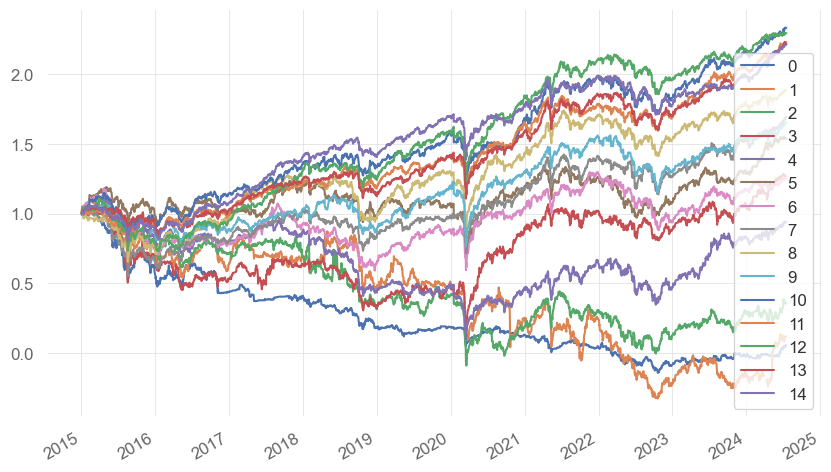

In [137]:
portfolio = backtest_daily_stocksort(q = 15)
((portfolio).cumsum() + 1).plot()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


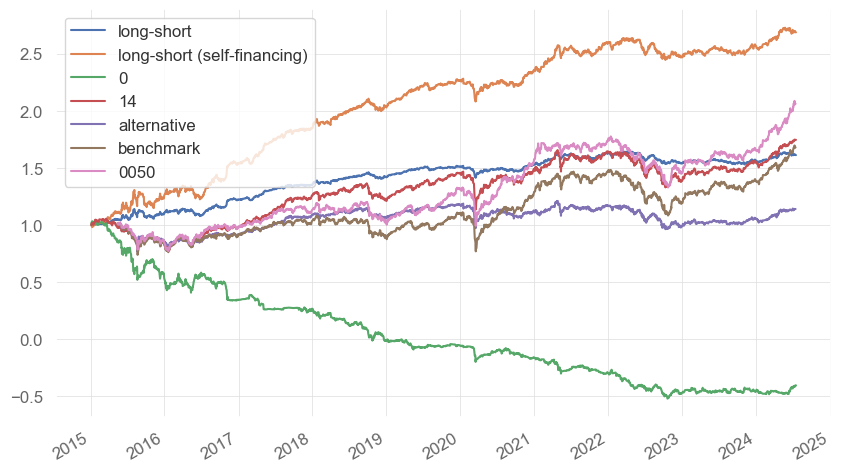

In [138]:
'''
交易成本估算：
    買進： 0.1425%
    賣出： 0.1425%
    證交稅： 0.3%
    每檔進出： 0.585%
    每季共 20*3 = 60 個交易日，平均每日交易成本 約 0.01%
'''
plot_portfolio(portfolio, tc = 0.0001)

In [139]:
qs.reports.metrics(portfolio, mode = 'Full')

                           0           1           2           3           4           5           6           7           8           9           10          11          12          13          14          long-short (self-financing)    long-short    benchmark    0050        reverse     alternative
-------------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------------------------  ------------  -----------  ----------  ----------  -------------
Start Period               2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25  2015-05-25                     2015-05-25    2015-05-25   2015-05-25  2015-05-25  2015-05-25
End Period                 2024-07-15  2024-07-15  2024-07-15  2024-07-15  2024-07-15  2024-07-1

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2024-07-17   2024-07-17
Risk-Free Rate             0.0%         0.0%
Time in Market             97.0%        100.0%

Cumulative Return          115.05%      68.41%
CAGR﹪                     12.35%       8.25%

Sharpe                     0.98         1.42
Prob. Sharpe Ratio         97.94%       99.77%
Smart Sharpe               0.97         1.41
Sortino                    1.44         1.92
Smart Sortino              1.44         1.91
Sortino/√2                 1.02         1.36
Smart Sortino/√2           1.02         1.35
Omega                      1.28         1.28

Max Drawdown               -36.04%      -14.36%
Longest DD Days            774          420
Volatility (ann.)          19.95%       8.68%
R^2                        0.0          0.0
Information Ratio          -0.02        -0.02
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-17,2020-03-17,2020-07-01,167,-14.360528,-11.811374
2,2022-03-22,2022-10-11,2023-05-15,420,-11.476521,-10.526082
3,2021-04-27,2021-05-13,2021-06-21,56,-9.097778,-6.868602
4,2021-07-02,2021-08-18,2021-11-15,137,-4.534591,-4.358335
5,2021-12-28,2022-01-21,2022-02-16,51,-3.387724,-3.121089


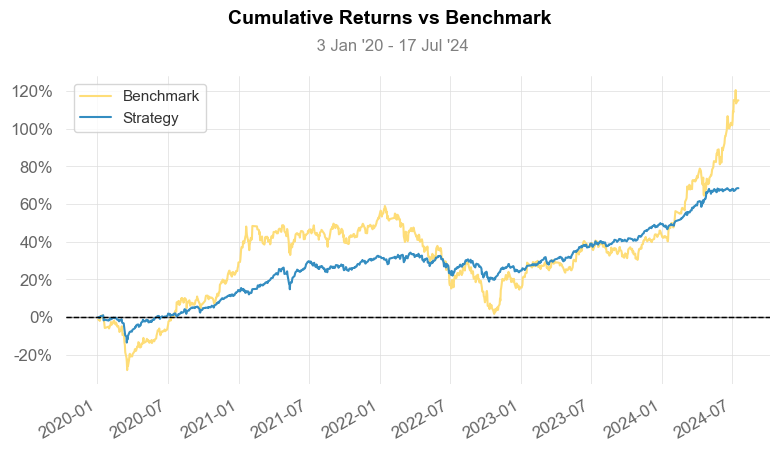

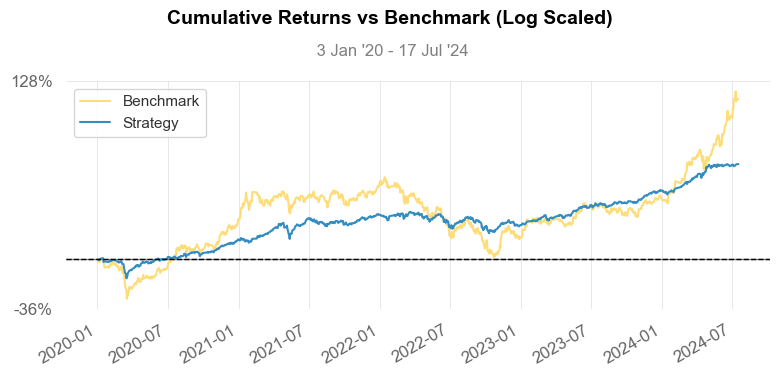

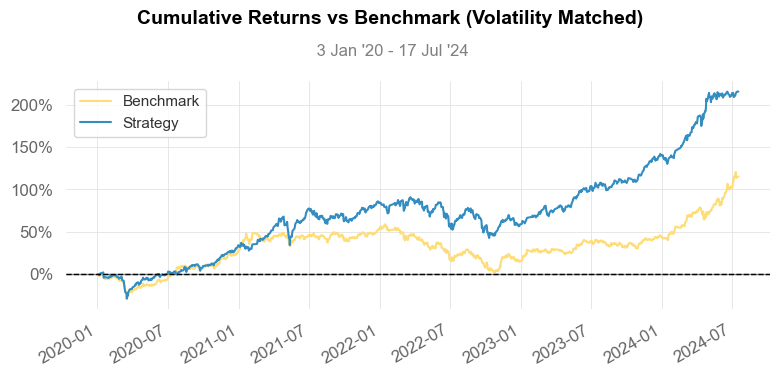

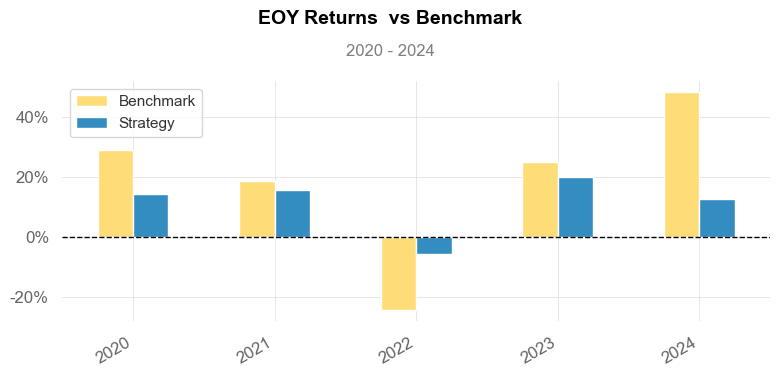

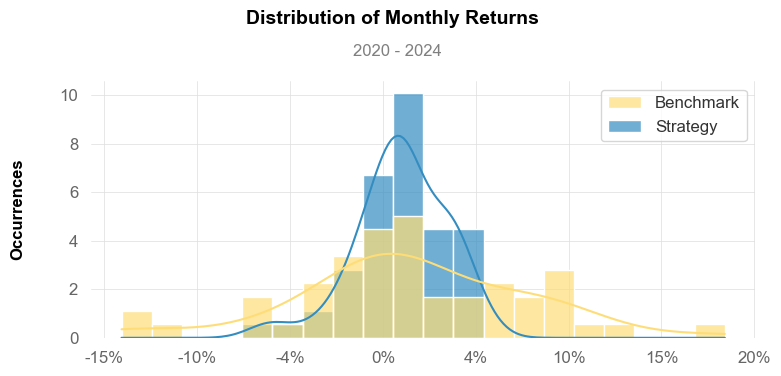

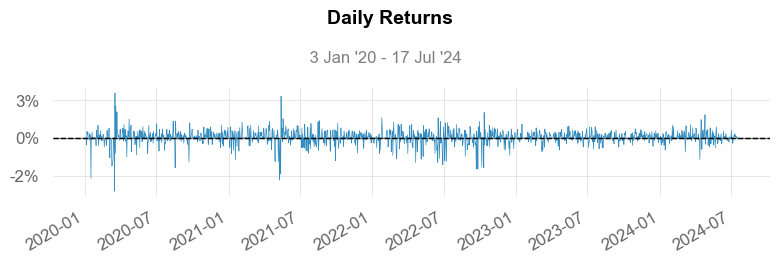

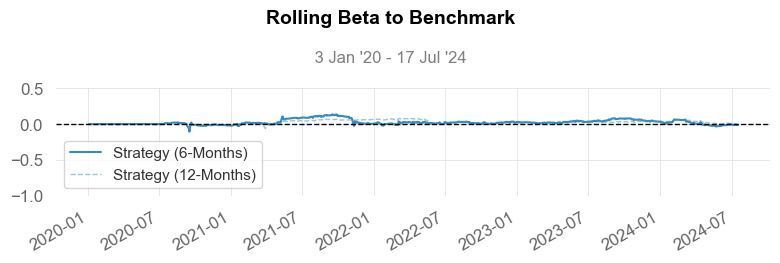

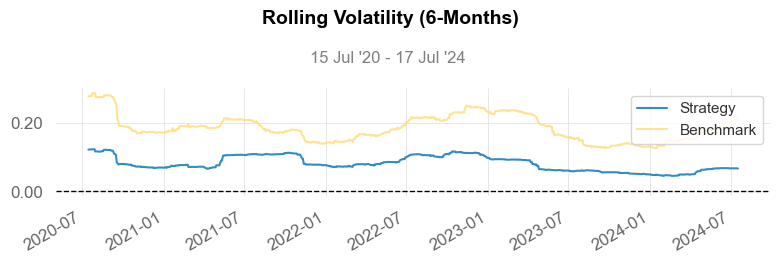

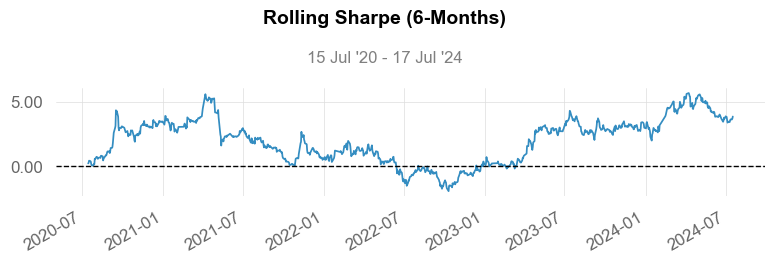

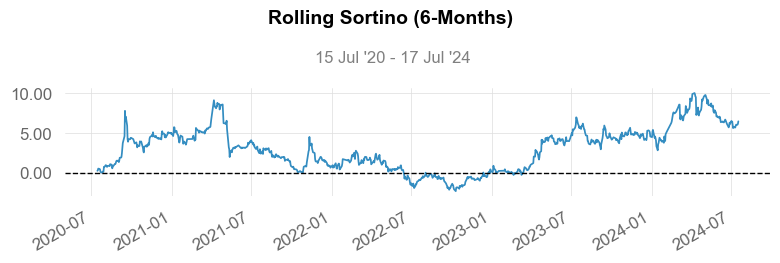

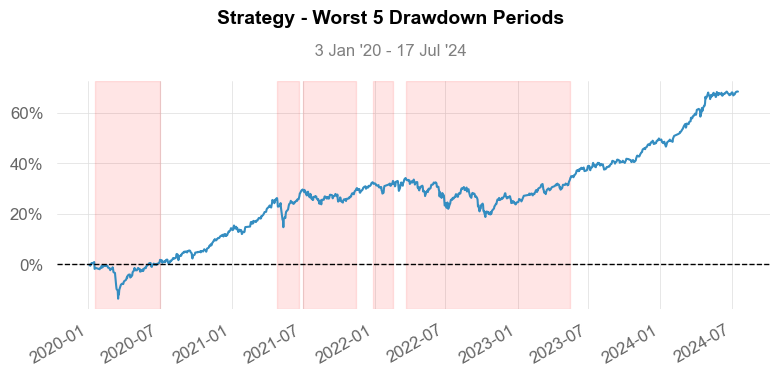

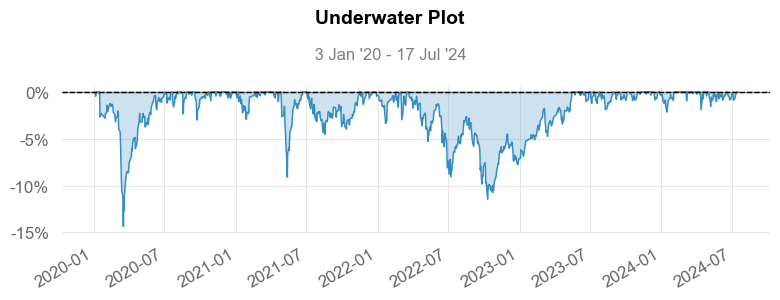

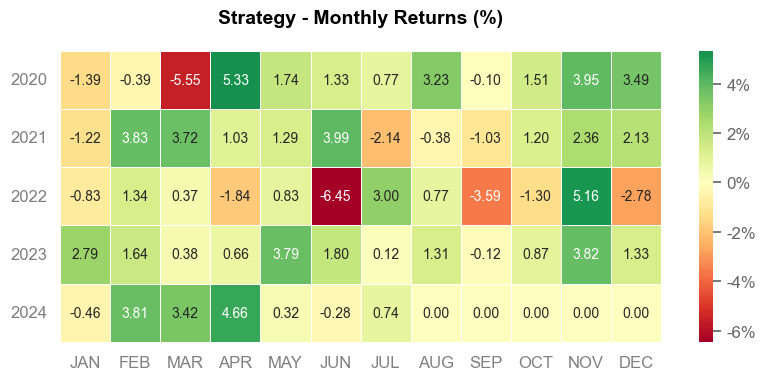

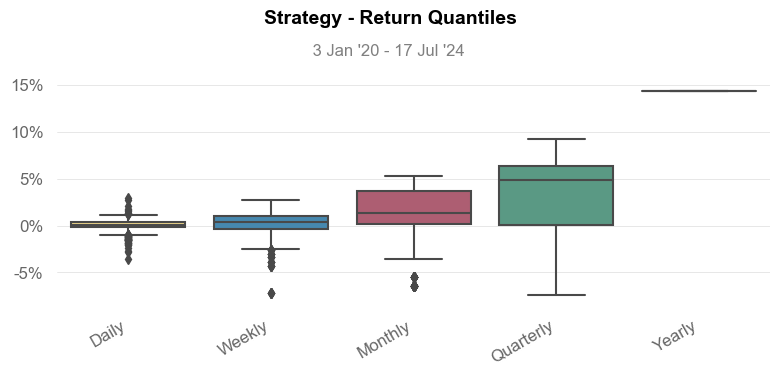

In [117]:
qs.reports.full(portfolio.loc['2020-01-01':, 'long-short'], benchmark=portfolio['0050'], active_returns = False)

In [ ]:
import quantstats as qs

qs.stats.sharpe(portfolio)
qs.plots.snapshot(portfolio[['long', 'short']])

In [ ]:
qs.reports.basic(portfolio[['long', 'short']])

In [ ]:
def backtest(data, clf, features_used):
    history = data.copy()
    history['logistic prediction'] = clf.predict(data[features_used])
    history = history.reset_index()

    dates = sorted(list(set(history['年月'])))

    seasonal_returns_long = [1]
    seasonal_returns_short = [1]
    for date in dates:
        print(date)
        current_stocks = history[history['年月'] == date]
        buy_stock = current_stocks[current_stocks['logistic prediction'] == True]
        sell_stock = current_stocks[current_stocks['logistic prediction'] == False]

        print('Long stocks: ' + str(list(buy_stock['證券代碼'])))
        print('Short stocks: ' + str(list(sell_stock['證券代碼'])))
        print(f'Stock bought: {len(list(buy_stock["證券代碼"]))}, Stock shorted: {len(list(sell_stock["證券代碼"]))}, Total: {len(list(buy_stock["證券代碼"]))+len(list(sell_stock["證券代碼"]))}')
        long = buy_stock['Seasonal Return'].mean()
        short = -sell_stock['Seasonal Return'].mean()
        seasonal_returns_long.append(long)
        seasonal_returns_short.append(short)


    long_portfolio = pd.Series(seasonal_returns_long)
    long_portfolio.cumsum().plot()
    short_portfolio = pd.Series(seasonal_returns_short)
    short_portfolio.cumsum().plot()

    long_short_portfolio = (long_portfolio + short_portfolio)/2
    long_short_portfolio.cumsum().plot()


backtest(data_test, reg, features_used)


'''
history = data_test.copy()
history['logistic prediction'] = reg.predict(data_test[features_used])
history = history.reset_index()

dates = sorted(list(set(history['年月'])))

seasonal_returns_long = [1]
seasonal_returns_short = [1]
for date in dates:
    print(date)
    current_stocks = history[history['年月'] == date]
    buy_stock = current_stocks[current_stocks['logistic prediction'] == True]
    print(list(buy_stock['證券代碼']))
    sell_stock = current_stocks[current_stocks['logistic prediction'] == False]
    long = buy_stock['Seasonal Return'].mean()
    short = -sell_stock['Seasonal Return'].mean()
    seasonal_returns_long.append(long)
    seasonal_returns_short.append(short)


long_portfolio = pd.Series(seasonal_returns_long)
long_portfolio.cumsum().plot()
short_portfolio = pd.Series(seasonal_returns_short)
short_portfolio.cumsum().plot()

long_short_portfolio = (long_portfolio + short_portfolio)/2
long_short_portfolio.cumsum().plot()

'''
